In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
from scipy.stats import wasserstein_distance, energy_distance
from matplotlib.backends.backend_pdf import PdfPages
import json
import pandas as pd

triton/project/ecanet

In [3]:
SAVE_MODE = 0

### I. Load the data

In [4]:
def easier_indexing(Gs):
    """
        Quick tool for easier indexing 
    """
    keys = [Gs[i][1][:-5] for i in range(len(Gs))]
    topic_dict = dict(zip(keys, list(range(len(keys)))))
    return topic_dict

In [5]:
GL = pickle.load(open("data/graphlistnew.pickle", "rb" ))
topic_dict = easier_indexing(GL)

### II. Identify the cores

In [6]:
def find_main_core(G, k=None):
    
    core_subgraph = nx.k_core(G, k=None, core_number=None)
    
    return core_subgraph

In [7]:
def get_colormap(G, core_subgraph, colors):
    
    color_map = []
    for node in G:
        if node in core_subgraph.nodes():
            color_map.append(color[0])
        else: 
            color_map.append(color[1]) 
    
    return color_map

In [8]:
def find_n_cores(network, n):
    
    colorlist = ["red", "blue", "orange", "green", "yellow", "brown"]
    cores = dict()
    
    G = network.copy()
    
    for i in range(n):
    
        cores[i] = find_main_core(G)
        
        for node in cores[i].nodes:
            G.remove_node(node)
           
    return cores

In [9]:
def color_cores(cores, network):
    
    color_map = []

    for node in network:
        if node in cores[0]:
            color_map.append("red")
        elif node in cores[1]:
            color_map.append("blue")
        else: 
            color_map.append("gray") 
    
    return color_map

### III. Measure the core polarization

1. Updated random walk based score. Pick from each cores the node with highest closeness centrality to be influencer. Start random walk.

In [10]:
def perform_randomwalk(G, starting_node, li, ri):
    
    found = 0
    end_side = 0
    which_random_starting_node = starting_node
   
    while (found != 1):
        neighbors = list(G.neighbors(which_random_starting_node))
        next_node = random.choice(neighbors)
        if (next_node in li):
            end_side = "A"
            found = 1  
        elif (next_node in ri):
            end_side = "B"
            found = 1
        else:
            which_random_starting_node = next_node       
    return end_side

def random_walk(backbone, cores, n_iter):
    
    centrality_core1 = nx.closeness_centrality(cores[0])
    centrality_core2 = nx.closeness_centrality(cores[1])
    
    A = max(centrality_core1, key=centrality_core1.get)
    B = max(centrality_core2, key=centrality_core2.get)
    
    AA = 0
    AB = 0
    BB = 0
    BA = 0
    
    starting_nodes = random.choices(list(cores[0]) + list(cores[1]), k=n_iter)
    
    for node in starting_nodes:
        
        res = perform_randomwalk(backbone, node, [A], [B])
        
        if node in cores[0] and res == "A":
            AA += 1
        
        elif node in cores[0] and res == "B":
            AB += 1
            
        elif node in cores[1] and res == "B":
            BB += 1
            
        elif node in cores[1] and res == "A":
            BA += 1
            
        else:
            print("Not possible!")
            
            
    pAA = AA/(AA+AB)
    pAB = 1-pAA
    
    pBB = BB/(BB+BA)
    pBA = 1-pBB
        
    
    return(pAA*pBB - pAB*pBA)

2. Accessibility (flow) based score, where p=0.5 and k=3. **A** measures the expected number of times that node **v** will hear about a cascade originating at node **u**, using walks of length up to **k**. The distance between the core-specific distributions is measured with *wasserstein* metric. 

In [11]:
def accessibility_score(backbone, cores, p=0.5):
    
    nodelist = list(cores[0]) + list(cores[1])
    M = nx.to_numpy_matrix(backbone, nodelist=nodelist)
    
    A = p*M + p**2 * M**2 + p**3*M**3
    n_core1 = len(cores[0])
    
    core1_intra = A[:n_core1, :n_core1].flatten().tolist()[0]
    core2_intra = A[n_core1:, n_core1:].flatten().tolist()[0]
    core_inter = A[:n_core1, n_core1:].flatten().tolist()[0]
    
    EMD = wasserstein_distance(core1_intra + core2_intra, core_inter)
    ENR = energy_distance(core1_intra + core2_intra, core_inter)
    
    return(np.var(A), EMD, ENR)

3. Assortativity

In [12]:
def assortativity(backbone):
    r=nx.degree_assortativity_coefficient(backbone)
    return r

4. Spectral approach

In [13]:
def algebraic_connectivity(backbone):
    
    ac = nx.algebraic_connectivity(backbone)
    normalized_ac = nx.algebraic_connectivity(backbone, normalized=True)
    
    return (ac, normalized_ac)

### IV. Analytical pipeline

In [14]:
spectral_snails = ["jotainrajaa", "samasuunta", "piraatit"]
disconnected_cores = ["vaalikone"]

In [18]:
def compute_core_polarization(net):
    
    G = net.copy()
    
    # Remove self-retweets
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Find two cores
    cores = find_n_cores(G, 2)
    
    # Take core subgraph
    backbone_nodes = (nx.compose_all(cores.values())).nodes
    backbone = G.subgraph(backbone_nodes)
    
    # Save values into a dictionary
    score_dict = dict()
    
    if t not in disconnected_cores:
        score_dict["RW"] = random_walk(backbone, cores, 1000)
        #print("RW completed.")
    else:
        score_dict["RW"] = 0
        #print("Disconnected core detected...")
    
    if t not in spectral_snails:
        score_dict["AC"] = algebraic_connectivity(backbone)[0]
        score_dict["nAC"] = algebraic_connectivity(backbone)[1]
        #print("AC completed.")
    else:
        score_dict["AC"] = (0,0)
        #print("Snail detected...")
        
    score_dict["varFLOW"] = accessibility_score(backbone, cores)[0]
    score_dict["wasFLOW"] = accessibility_score(backbone, cores)[1]
    score_dict["eneFLOW"] = accessibility_score(backbone, cores)[2]
    #print("FLOW completed.")
    
    score_dict["ASSOR"] = assortativity(backbone)
    #print("ASSOR completed.")

    return score_dict

Compute the core polarization scores for selected topics

In [19]:
core_polarization = dict()

In [20]:
all_topics = list(topic_dict.keys())

polarized_topics = ["kokoomus", 
                    "vihreät", 
                    "perussuomalaiset", 
                    "vasemmisto", 
                    "vihapuhe", 
                    "ilmastonmuutos", 
                    "maahanmuutto",
                    "sote",
                    "ilmastovaalit"]

unpolarized_topics = ["mielenterveys", 
                      "liikenne", 
                      "kunnat", 
                      "tekoäly", 
                      "nuoret", 
                      "urheilu", 
                      "yrittäjät",
                      "yrittäjyys",
                      "rekry",
                      "osaaminen",
                      "johtaminen"]

In [ ]:
for t in all_topics:
    
    print("Starting to process the topic: ", t)
    #Load the network
    network = GL[topic_dict[t]][0][0][0]
    
    #Compute all scores for core polarization
    core_polarization[t] = compute_core_polarization(network)

    print("Following topic completed: : ", t)
    print("\n")

In [ ]:
if SAVE_MODE:

    # Save results to file
    with open('results2.json', 'w') as fp:
        json.dump(core_polarization, fp)

### V. Visualization pipeline

*later*

### VI. Results

ORDER

In [22]:
df = pd.DataFrame.from_dict(core_polarization).T
df

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
aktiivimalli,0.250084,1.96503,0.248907,30.6049,6.54326,2.37405,0.110113
ammatillinenkoulutus,0.661588,0.358265,0.102289,35.6484,8.22197,3.21287,-0.140775
arvot,0.442593,0.131889,0.0231745,2.20834,0.964025,0.632422,-0.0638994
demokratia,0.673865,0.197761,0.0260892,2.71325,1.88907,1.38475,-0.0877943
digitalisaatio,0.468107,0.167264,0.0413733,3.0056,1.42948,0.968934,-0.0907307
...,...,...,...,...,...,...,...
yleastudio,0.803239,0.315258,0.0537508,1.3565,0.798903,0.701969,0.00701685
yliopisto,0.0798864,2.05885,0.267903,20.3954,1.67387,0.563569,0.0346721
ympäristö,0.942452,0.0564611,0.00603905,23.2485,7.90076,3.42747,0.0424479
yrittäjyys,0.546596,0.082447,0.0196148,1.70795,1.01214,0.847431,-0.134687


RW

In [23]:
df.sort_values(by=['RW'], ascending=False).head(15)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
tulevaisuus,1,0,0,100.051,17.16,5.15291,0.190548
sdp,1,0,0,353.1,31.3868,6.94364,0.020627
eu,1,0,0,422977,622.006,20.7012,0.760404
helsinki,1,0,0,15.5423,2.86037,1.51391,-0.0688836
ympäristö,0.942452,0.0564611,0.00603905,23.2485,7.90076,3.42747,0.0424479
maahanmuutto,0.869932,0.111925,0.0104504,213.048,20.9535,5.28989,0.0319562
koulutusratkaisee,0.825951,0.23146,0.0260829,26.3596,8.9627,3.65456,0.104814
journalismi,0.806764,0.187809,0.0221851,8.49321,3.49969,1.89281,-0.298354
yleastudio,0.803239,0.315258,0.0537508,1.3565,0.798903,0.701969,0.00701685
sananvapaus,0.793476,0.07078,0.0110644,4.89662,2.31654,1.40009,0.0343616


AC

In [24]:
df = df.drop(["jotainrajaa", "samasuunta", "piraatit", "vaalikone"])
df.sort_values(by=["AC"], ascending=True).head(20)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
helsinki,1,0,0,15.5423,2.86037,1.51391,-0.0688836
tulevaisuus,1,0,0,100.051,17.16,5.15291,0.190548
sdp,1,0,0,353.1,31.3868,6.94364,0.020627
eu,1,0,0,422977,622.006,20.7012,0.760404
rekry,0.0872284,0.00768261,0.00388846,0.021304,0.0140087,0.0174136,-0.101554
urheilu,0.066778,0.0102526,0.00472183,0.0248811,0.0266758,0.0333474,-0.162432
ilmastomarssi,0.0648379,0.0475013,0.00909193,38.0804,2.21184,0.698195,0.17755
ympäristö,0.942452,0.0564611,0.00603905,23.2485,7.90076,3.42747,0.0424479
sananvapaus,0.793476,0.07078,0.0110644,4.89662,2.31654,1.40009,0.0343616
yrittäjyys,0.546596,0.082447,0.0196148,1.70795,1.01214,0.847431,-0.134687


nAC

In [25]:
df.sort_values(by=["nAC"], ascending=True).head(20)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
tulevaisuus,1,0,0,100.051,17.16,5.15291,0.190548
sdp,1,0,0,353.1,31.3868,6.94364,0.020627
helsinki,1,0,0,15.5423,2.86037,1.51391,-0.0688836
eu,1,0,0,422977,622.006,20.7012,0.760404
rekry,0.0872284,0.00768261,0.00388846,0.021304,0.0140087,0.0174136,-0.101554
urheilu,0.066778,0.0102526,0.00472183,0.0248811,0.0266758,0.0333474,-0.162432
ympäristö,0.942452,0.0564611,0.00603905,23.2485,7.90076,3.42747,0.0424479
ilmastomarssi,0.0648379,0.0475013,0.00909193,38.0804,2.21184,0.698195,0.17755
vasemmisto,0.793079,0.177313,0.00962269,354.554,21.6075,4.53447,0.260458
maahanmuutto,0.869932,0.111925,0.0104504,213.048,20.9535,5.28989,0.0319562


varFLOW

In [26]:
df.sort_values(by=["varFLOW"], ascending=False).head(20)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
eu,1,0,0,422977,622.006,20.7012,0.760404
ilmasto,0.455756,0.812122,0.0295599,7631.08,116.685,11.5688,0.210494
vaalit,0.0135687,3.17611,0.0601633,6079.03,62.0826,6.36876,-0.0230321
vaalit2019,0.229498,2.23845,0.0509844,3349.82,85.4905,10.3425,-0.0683626
ilmastovaalit,0.518737,0.663055,0.0670988,1655.26,68.1925,9.92796,0.190223
kokoomus,0.501194,0.778309,0.0284571,1023.13,36.953,5.99369,0.0131208
ilmastonmuutos,0.652271,0.366288,0.0221728,978.459,44.2886,7.47718,0.16792
sote,0.159972,1.79885,0.0898443,587.096,30.4281,5.46102,0.247796
ilmastolakko,0.691261,0.172927,0.017545,399.834,25.5633,5.43471,0.0896093
vasemmisto,0.793079,0.177313,0.00962269,354.554,21.6075,4.53447,0.260458


wasFLOW

**TOP 25**

In [27]:
df.sort_values(by=["wasFLOW"], ascending=False).head(25)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
eu,1,0,0,422977,622.006,20.7012,0.760404
ilmasto,0.455756,0.812122,0.0295599,7631.08,116.685,11.5688,0.210494
vaalit2019,0.229498,2.23845,0.0509844,3349.82,85.4905,10.3425,-0.0683626
ilmastovaalit,0.518737,0.663055,0.0670988,1655.26,68.1925,9.92796,0.190223
vaalit,0.0135687,3.17611,0.0601633,6079.03,62.0826,6.36876,-0.0230321
ilmastonmuutos,0.652271,0.366288,0.0221728,978.459,44.2886,7.47718,0.16792
kokoomus,0.501194,0.778309,0.0284571,1023.13,36.953,5.99369,0.0131208
sdp,1,0,0,353.1,31.3868,6.94364,0.020627
sote,0.159972,1.79885,0.0898443,587.096,30.4281,5.46102,0.247796
ilmastolakko,0.691261,0.172927,0.017545,399.834,25.5633,5.43471,0.0896093


**LEAST 15**

In [28]:
df.sort_values(by=["wasFLOW"], ascending=True).head(25)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
rekry,0.0872284,0.00768261,0.00388846,0.021304,0.0140087,0.0174136,-0.101554
urheilu,0.066778,0.0102526,0.00472183,0.0248811,0.0266758,0.0333474,-0.162432
tampere,0.243518,0.25773,0.0549633,0.938745,0.0438479,0.0390485,-0.0192153
tekoäly,0.234749,0.137939,0.0438063,0.193964,0.0567999,0.076125,-0.0814939
osallisuus,0.128806,0.160195,0.0484785,1.1735,0.0878507,0.0718782,-0.00466297
eriarvoisuus,0.0376651,0.0842121,0.0255878,0.620773,0.18472,0.132191,0.061363
viestintä,0.0617832,0.759259,0.164128,0.808944,0.19265,0.144768,-0.0347058
osaaminen,0.0989229,0.244574,0.0584215,2.33443,0.405596,0.351453,0.0816015
köyhyys,0.104756,0.459853,0.149097,4.84723,0.580578,0.332689,0.0127211
tasaarvo,0.0634754,0.398942,0.0853667,2.7722,0.61494,0.508404,-0.00763021


eneFLOW

In [29]:
df.sort_values(by=["eneFLOW"], ascending=False).head(15)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
eu,1,0,0,422977,622.006,20.7012,0.760404
ilmasto,0.455756,0.812122,0.0295599,7631.08,116.685,11.5688,0.210494
vaalit2019,0.229498,2.23845,0.0509844,3349.82,85.4905,10.3425,-0.0683626
ilmastovaalit,0.518737,0.663055,0.0670988,1655.26,68.1925,9.92796,0.190223
ilmastonmuutos,0.652271,0.366288,0.0221728,978.459,44.2886,7.47718,0.16792
sdp,1,0,0,353.1,31.3868,6.94364,0.020627
vaalit,0.0135687,3.17611,0.0601633,6079.03,62.0826,6.36876,-0.0230321
kokoomus,0.501194,0.778309,0.0284571,1023.13,36.953,5.99369,0.0131208
keskusta,0.699734,0.275951,0.0156018,182.027,21.8067,5.55577,-0.131686
sote,0.159972,1.79885,0.0898443,587.096,30.4281,5.46102,0.247796


ASSOR

In [30]:
df.sort_values(by=["ASSOR"], ascending=False).head(15)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
eu,1,0,0,422977,622.006,20.7012,0.760404
tiedevaalit,0.583163,0.544261,0.121856,12.4199,4.71591,2.21032,0.377093
vasemmisto,0.793079,0.177313,0.00962269,354.554,21.6075,4.53447,0.260458
sote,0.159972,1.79885,0.0898443,587.096,30.4281,5.46102,0.247796
hallitus,0.413438,0.418521,0.0387292,144.025,13.9591,3.7269,0.234849
ilmasto,0.455756,0.812122,0.0295599,7631.08,116.685,11.5688,0.210494
tulevaisuus,1,0,0,100.051,17.16,5.15291,0.190548
ilmastovaalit,0.518737,0.663055,0.0670988,1655.26,68.1925,9.92796,0.190223
ilmastomarssi,0.0648379,0.0475013,0.00909193,38.0804,2.21184,0.698195,0.17755
ilmastonmuutos,0.652271,0.366288,0.0221728,978.459,44.2886,7.47718,0.16792


PLOTS (Discriminative power)

In [31]:
polarized_flow = []
unpolarized_flow = []

polarized_ac = []
unpolarized_ac = []

polarized_rw = []
unpolarized_rw = []

for t in polarized_topics:
    polarized_flow += [core_polarization[t]["wasFLOW"]]
    polarized_ac += [core_polarization[t]["AC"]]
    polarized_rw += [core_polarization[t]["RW"]]
    
for t in unpolarized_topics:
    unpolarized_flow += [core_polarization[t]["wasFLOW"]]
    unpolarized_ac += [core_polarization[t]["AC"]]
    unpolarized_rw += [core_polarization[t]["RW"]]

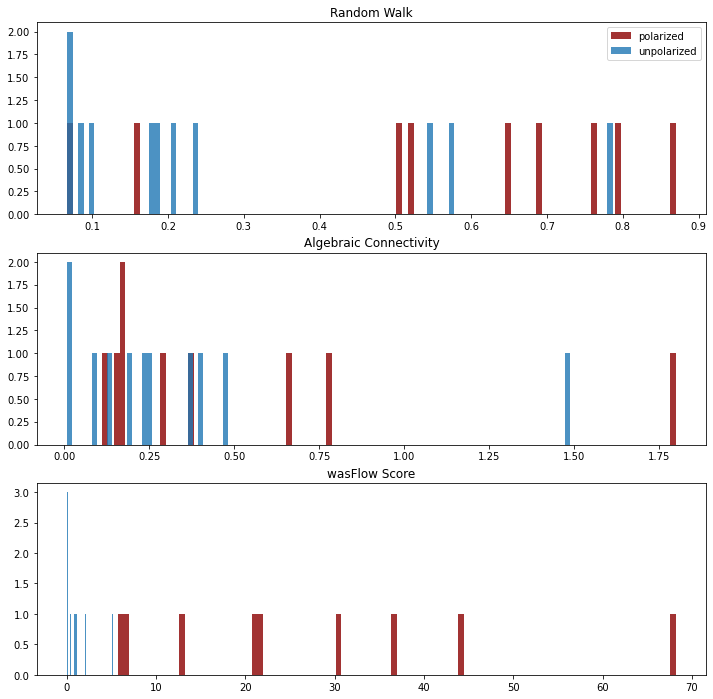

In [32]:
plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
plt.title("Random Walk")
plt.hist(polarized_rw, label="polarized", color="darkred", alpha=0.8, bins=100)
plt.hist(unpolarized_rw, label="unpolarized", alpha=0.8, bins=100)
plt.legend()

plt.subplot(3,1,2)
plt.title("Algebraic Connectivity")
plt.hist(polarized_ac, label="polarized", color="darkred", alpha=0.8, bins=100)
plt.hist(unpolarized_ac, label="unpolarized", alpha=0.8, bins=100)

plt.subplot(3,1,3)
plt.title("wasFlow Score")
plt.hist(polarized_flow, label="polarized", color="darkred", alpha=0.8, bins=100)
_ = plt.hist(unpolarized_flow, label="unpolarized", alpha=0.8, bins=100)

correlation between the scores

In [95]:
x, y, z, w, v = [], [], [], [], []
for t in core_polarization:
    x += [core_polarization[t]["varFLOW"]]
    y += [core_polarization[t]["wasFLOW"]]
    z += [core_polarization[t]["RW"]]
    w += [core_polarization[t]["AC"]]
    v += [core_polarization[t]["ASSOR"]]

In [147]:
df_num = df.astype("float")

In [84]:
corrmat = df_num.corr(method="spearman")

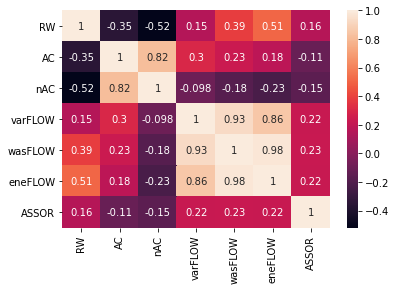

In [85]:
import seaborn as sn
sn.heatmap(corrmat, annot=True)
plt.show()

## STOP HERE 

In [1]:
with PdfPages('unpolarized2_pdf.pdf') as pdf:
    
    for t in unpolarized_topics:

        plt.figure(figsize=(12,12)) 
        plt.title(t + ", RW: " + str(round(core_polarization[t]["RW"],3)) + ", ACC: " + str(round(core_polarization[t]["AC"],3)) + ", FLOW: " + str(round(core_polarization[t]["wasFLOW"],3)))
        
        #Load the network
        network = GL[topic_dict[t]][0][0][0]
        G = network.copy()
    
        # Remove self-retweets
        G.remove_edges_from(nx.selfloop_edges(G))
    
        # Find two cores
        cores = find_n_cores(G, 2)
    
        # Take core subgraph
        cm = color_cores(cores, G)
        
        nx.draw_spring(G, node_size=30, width=0.5, alpha=0.1, node_color=cm)
        pdf.savefig()
        #plt.close()

        print("Topic visualized: ", t)

NameError: name 'PdfPages' is not defined

In [93]:
pd.set_option('display.max_rows', 100)

In [94]:
df.sort_values(by=["wasFLOW"], ascending=False)

,RW,AC,nAC,varFLOW,wasFLOW,eneFLOW,ASSOR
eu,1,0,0,422977,622.006,20.7012,0.760404
ilmasto,0.455756,0.812122,0.0295599,7631.08,116.685,11.5688,0.210494
vaalit2019,0.229498,2.23845,0.0509844,3349.82,85.4905,10.3425,-0.0683626
ilmastovaalit,0.518737,0.663055,0.0670988,1655.26,68.1925,9.92796,0.190223
vaalit,0.0135687,3.17611,0.0601633,6079.03,62.0826,6.36876,-0.0230321
ilmastonmuutos,0.652271,0.366288,0.0221728,978.459,44.2886,7.47718,0.16792
kokoomus,0.501194,0.778309,0.0284571,1023.13,36.953,5.99369,0.0131208
sdp,1,0,0,353.1,31.3868,6.94364,0.020627
sote,0.159972,1.79885,0.0898443,587.096,30.4281,5.46102,0.247796
ilmastolakko,0.691261,0.172927,0.017545,399.834,25.5633,5.43471,0.0896093


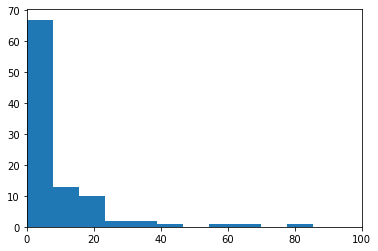

In [117]:
ax = plt.subplot()
_ = ax.hist(y, bins=80)
_ = ax.set_xlim(0,100)

In [119]:
np.median(y)

3.961320831685846

In [150]:
df_num = df_num.drop(["eu"])

In [133]:
df_num.columns

Index(['RW', 'AC', 'nAC', 'varFLOW', 'wasFLOW', 'eneFLOW', 'ASSOR'], dtype='object')

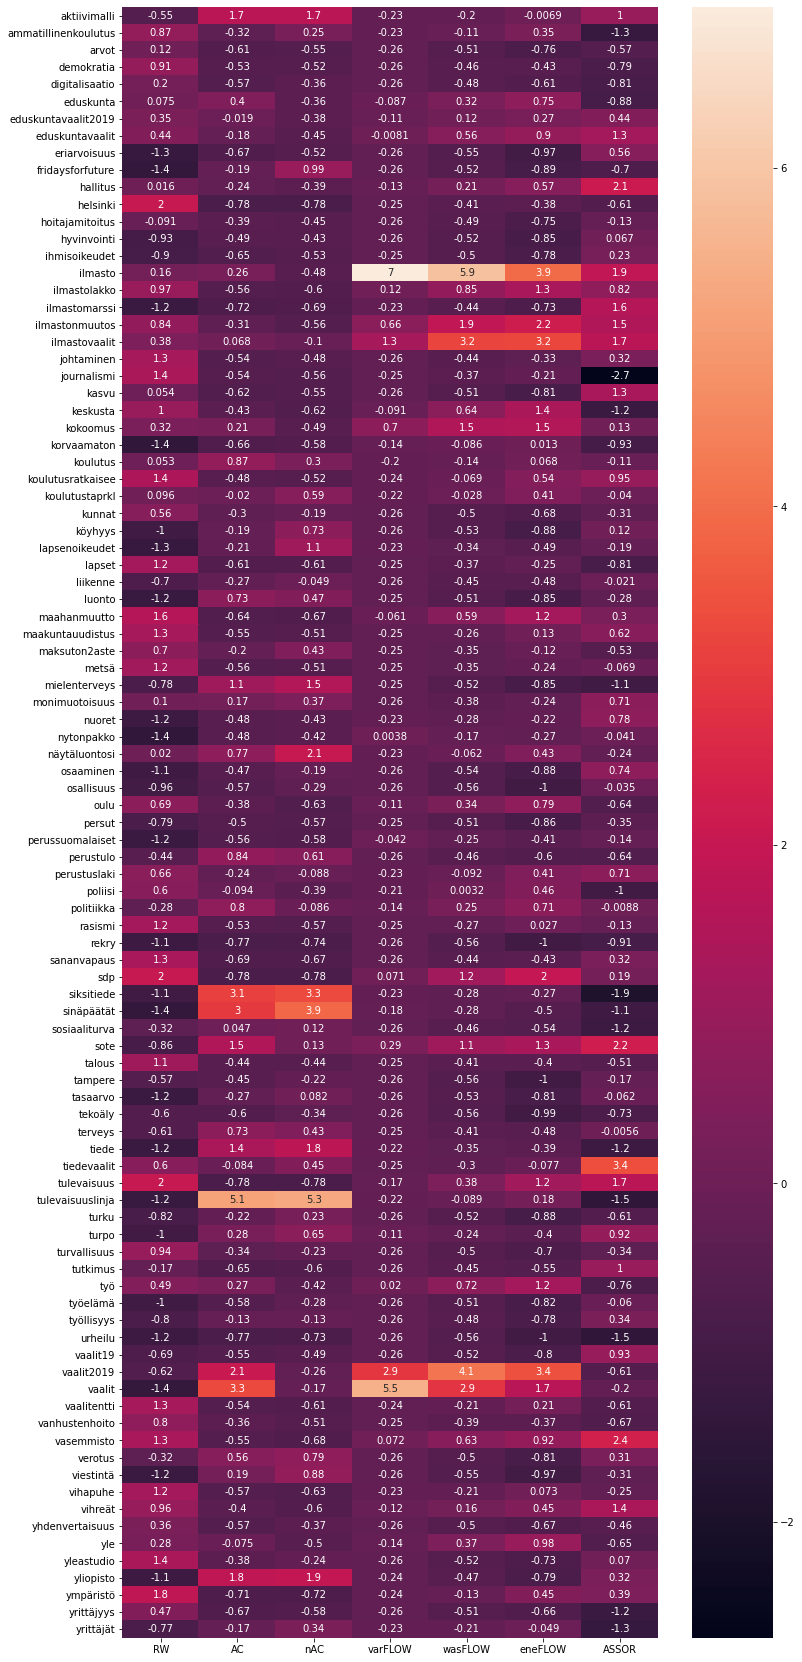

In [154]:
plt.figure(figsize=(12,30)) 
#plt.pcolor(df_num)
df_num_final=(df_num-df_num.mean())/df_num.std()
sn.heatmap(df_num_final, annot=True)
_ = plt.yticks(np.arange(0.5, len(df_num.index), 1), df_num.index)
_ = plt.xticks(np.arange(0.5, len(df_num.columns), 1), df_num.columns)

In [165]:
list(df_num_final[df_num_final["wasFLOW"] > 0].index)

['eduskunta',
 'eduskuntavaalit2019',
 'eduskuntavaalit',
 'hallitus',
 'ilmasto',
 'ilmastolakko',
 'ilmastonmuutos',
 'ilmastovaalit',
 'keskusta',
 'kokoomus',
 'maahanmuutto',
 'oulu',
 'poliisi',
 'politiikka',
 'sdp',
 'sote',
 'tulevaisuus',
 'työ',
 'vaalit2019',
 'vaalit',
 'vasemmisto',
 'vihreät',
 'yle']